# EJERCICIO NLP

**Análisis de las descripciones de experiencias laborales de una muestra de Data Scientist de Madrid puestas en Linkedin**

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


### INGRESO DE DATOS SCRAPEADOS, Y TRANSFORMACIONES MÍNIMAS

In [2]:
df=pd.read_csv("perfil_experiencia.csv",delimiter=";", error_bad_lines=False,na_values=["nope"],names=["#","n_perfil","Cargo","Empresa","Fechas","descripcion","jornada"])

In [3]:
df

,#,n_perfil,Cargo,Empresa,Fechas,descripcion,jornada
0,0,0,Data Scientist,Banco Santander,abr 2018 – actualidad,NaN,NaN
1,1,1,Data Scientist,GRUPO SOLUTIO,dic 2018 – actualidad,- Desarrollo de varios proyectos de principio...,NaN
2,2,1,Data Insight Analyst,Havas Sports & Entertainment,nov 2017 – ago 2018,- Recopilación automatizada de datos en Redes ...,NaN
3,3,1,Consultor,Innova - TSN,dic 2015 – oct 2017,- Inplementación y desarrollo de técnicas de M...,NaN
4,4,2,Data Scientist,Banco Santander,sept 2017 – actualidad,• Since 2019 I am part of data and model depar...,NaN
...,...,...,...,...,...,...,...
1238,1238,467,Machine Learning Intern,ALTEN,mar 2019 – ago 2019,During my internship I was inside Alten's Inno...,NaN
1239,1239,467,Data Science Intern,Leads Origins,feb 2018 – mar 2018,During my internship in Leads Origins I was in...,NaN
1240,1240,468,Data Scientist,Accenture Analytics,oct 2017 – actualidad,NaN,NaN
1241,1241,468,Functional & Industry Analytics Intern,Accenture España,sept 2016 – oct 2017,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   #            1243 non-null   int64 
 1   n_perfil     1243 non-null   int64 
 2   Cargo        1243 non-null   object
 3   Empresa      1243 non-null   object
 4   Fechas       1243 non-null   object
 5   descripcion  713 non-null    object
 6   jornada      366 non-null    object
dtypes: int64(2), object(5)
memory usage: 68.1+ KB


In [5]:
df["jornada"].fillna("completa",inplace=True)

In [6]:
df1=df.dropna()

In [7]:
df1=df1[["Cargo","Empresa","descripcion"]]

In [8]:
df1["descripcion"].iloc[0]

'- Desarrollo de varios proyectos de  principio a fin tanto en R como  en Python cuyo objetivo es extraer información de diferentes documentos, utilizando para ello Redes Neuronales para detección de objetos y tratamiento de imágenes con open CV- Análisis estadístico de datos en el ámbito bancario.- Herramientas y software utilizado --> R, Python (open CV, Keras, Tensorflow, Fastai, PyTorch), docker, bash.- Redes Neuronales utilizadas --> YOLO, RetinaNet, Mxnet   …  ver más'

### TOKENIZACIÓN  DE LAS DESCRIPCIONES

Donde cada documento será la descripción de un puesto

In [9]:
df2=df1["descripcion"].apply(lambda x: nltk.word_tokenize(x,"spanish"))

In [10]:
df1["tokenizado"]=df2

In [11]:
palabras_funcionales=nltk.corpus.stopwords.words("spanish")
inf_funcionales=nltk.corpus.stopwords.words("english")
palabras_funcionales.extend([".", ",", ":", ";", "!", "?","'","-","â€¢","(",")",'�','m�s','ver',"¬Â¢","Ã¢â","•" ])
palabras_funcionales.extend(inf_funcionales)
frecuentes=[]
for ind in range(len(df1["tokenizado"])):
    tokens_limpios=list()
    for tok in df1["tokenizado"].iloc[ind]:
        tok.lower()
        if tok.lower() not in palabras_funcionales:
            tokens_limpios.append(tok.lower())
            
    frecuentes.extend(tokens_limpios)
    df1["tokenizado"].iat[ind]=tokens_limpios
        
# df1["tokenizado"]=df1["tokenizado"].apply(lambda x: tok.lower() for tok in x)
# df1["tokenizado"]=df1["tokenizado"].apply(lambda x:[tok for tok in x if tok not in palabras_funcionales])
# tokens_limpios=[] 
# tokens = [token.lower() for token in tokens]
# for token in tokens: 
#     if token not in palabras_funcionales: 
#         tokens_limpios.append(token)

In [12]:
distribucion=nltk.FreqDist(frecuentes)


In [13]:
distribucion

FreqDist({'data': 400, '…': 334, 'learning': 190, 'datos': 145, 'machine': 134, 'python': 126, 'analysis': 120, 'development': 114, 'análisis': 104, 'desarrollo': 87, ...})

In [14]:
df1

,Cargo,Empresa,descripcion,tokenizado
1,Data Scientist,GRUPO SOLUTIO,- Desarrollo de varios proyectos de principio...,"[desarrollo, varios, proyectos, principio, fin..."
2,Data Insight Analyst,Havas Sports & Entertainment,- Recopilación automatizada de datos en Redes ...,"[recopilación, automatizada, datos, redes, soc..."
3,Consultor,Innova - TSN,- Inplementación y desarrollo de técnicas de M...,"[inplementación, desarrollo, técnicas, machine..."
4,Data Scientist,Banco Santander,• Since 2019 I am part of data and model depar...,"[since, 2019, part, data, model, department, g..."
5,Profesor Big Data y Data Science,ISEB,Desarrollo y exposición de sesiones relacionad...,"[desarrollo, exposición, sesiones, relacionada..."
...,...,...,...,...
1235,Data Scientist,Olocip,Development of a project from scratch that goe...,"[development, project, scratch, goes, etl, pro..."
1237,Data Scientist,ALTEN,These months I've been supporting Alten's Inno...,"[months, 've, supporting, alten, 's, innovatio..."
1238,Machine Learning Intern,ALTEN,During my internship I was inside Alten's Inno...,"[internship, inside, alten, 's, innovation, la..."
1239,Data Science Intern,Leads Origins,During my internship in Leads Origins I was in...,"[internship, leads, origins, charge, different..."


### SEPARACION DE TOKENS EN COLUMNAS

In [15]:
conjunto=set()
for n in range(len(df1["tokenizado"])):
    for f in df1["tokenizado"].iloc[n]:
        if f in conjunto:
            if df1[f].iloc[n] > 0:
                df1[f].iat[n]+=1
            else:
                df1[f].iat[n]=1
        else:
            conjunto.add(f)
            df1[f]=0
            df1[f].iat[n]=1
        

In [16]:
df1

,Cargo,Empresa,descripcion,tokenizado,desarrollo,varios,proyectos,principio,fin,r,...,behaviors,aclient,leads,origins,tweets,bots.-,pickle,pymysql,well-know,unitarios
1,Data Scientist,GRUPO SOLUTIO,- Desarrollo de varios proyectos de principio...,"[desarrollo, varios, proyectos, principio, fin...",1,1,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
2,Data Insight Analyst,Havas Sports & Entertainment,- Recopilación automatizada de datos en Redes ...,"[recopilación, automatizada, datos, redes, soc...",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Consultor,Innova - TSN,- Inplementación y desarrollo de técnicas de M...,"[inplementación, desarrollo, técnicas, machine...",1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Data Scientist,Banco Santander,• Since 2019 I am part of data and model depar...,"[since, 2019, part, data, model, department, g...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Profesor Big Data y Data Science,ISEB,Desarrollo y exposición de sesiones relacionad...,"[desarrollo, exposición, sesiones, relacionada...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,Data Scientist,Olocip,Development of a project from scratch that goe...,"[development, project, scratch, goes, etl, pro...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1237,Data Scientist,ALTEN,These months I've been supporting Alten's Inno...,"[months, 've, supporting, alten, 's, innovatio...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1238,Machine Learning Intern,ALTEN,During my internship I was inside Alten's Inno...,"[internship, inside, alten, 's, innovation, la...",0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1239,Data Science Intern,Leads Origins,During my internship in Leads Origins I was in...,"[internship, leads, origins, charge, different...",0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,0


In [17]:
columnas=df1.columns
columnas= list(columnas)
columnas.remove('Cargo')
columnas.remove('Empresa')
columnas.remove('descripcion')
columnas.remove('tokenizado')


### CÁLCULO DEL TF IDF para todas las columnas

In [18]:
for c in columnas:
    tf=df1[c].sum()
    n_docs = len(df1)
    idf = math.log((n_docs+1) / (1+len(df1[df1[c]> 0 ].index)))
    tfidf = tf * (idf + 1)
    df1[c]=df1[c].map(lambda x: tfidf if x>0 else 0)

In [19]:
df1

,Cargo,Empresa,descripcion,tokenizado,desarrollo,varios,proyectos,principio,fin,r,...,behaviors,aclient,leads,origins,tweets,bots.-,pickle,pymysql,well-know,unitarios
1,Data Scientist,GRUPO SOLUTIO,- Desarrollo de varios proyectos de principio...,"[desarrollo, varios, proyectos, principio, fin...",289.047732,6.877736,6.877736,6.877736,6.877736,24.738354,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Data Insight Analyst,Havas Sports & Entertainment,- Recopilación automatizada de datos en Redes ...,"[recopilación, automatizada, datos, redes, soc...",0.000000,0.000000,0.000000,0.000000,0.000000,24.738354,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Consultor,Innova - TSN,- Inplementación y desarrollo de técnicas de M...,"[inplementación, desarrollo, técnicas, machine...",289.047732,0.000000,0.000000,0.000000,0.000000,24.738354,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Data Scientist,Banco Santander,• Since 2019 I am part of data and model depar...,"[since, 2019, part, data, model, department, g...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Profesor Big Data y Data Science,ISEB,Desarrollo y exposición de sesiones relacionad...,"[desarrollo, exposición, sesiones, relacionada...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,Data Scientist,Olocip,Development of a project from scratch that goe...,"[development, project, scratch, goes, etl, pro...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1237,Data Scientist,ALTEN,These months I've been supporting Alten's Inno...,"[months, 've, supporting, alten, 's, innovatio...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1238,Machine Learning Intern,ALTEN,During my internship I was inside Alten's Inno...,"[internship, inside, alten, 's, innovation, la...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.877736,6.877736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1239,Data Science Intern,Leads Origins,During my internship in Leads Origins I was in...,"[internship, leads, origins, charge, different...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,6.877736,6.877736,6.877736,6.877736,6.877736,6.877736,6.877736,0.000000


### SELECCIÓN DE DATOS DEL PERCENTIL O.8 para arriba

In [20]:
lista_df=[]
for c in df1.columns[5:]:
    lista_df.append(df1[c].max())


{'whiskers': [<matplotlib.lines.Line2D at 0x135003dcf70>,
 'caps': [<matplotlib.lines.Line2D at 0x135003fa670>,
 'boxes': [<matplotlib.lines.Line2D at 0x135003dcc10>],
 'medians': [<matplotlib.lines.Line2D at 0x135003fad30>],
 'fliers': [<matplotlib.lines.Line2D at 0x13500a960d0>],
 'means': []}

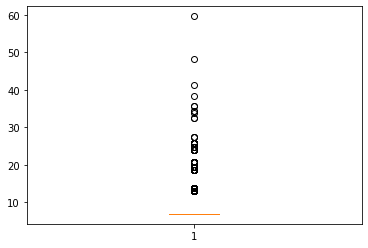

In [21]:
plt.boxplot(lista_df)

In [22]:
a = np.array(lista_df)
p = np.percentile(a, 80)
print(p)

6.877735781779639


In [23]:
pordebajo=[]
for c in df1.columns[5:]:
    if df1[c].max() <=7.432940092739179:
        pordebajo.append(c)
df2=df1.drop(pordebajo,axis=1)

In [24]:
df2

,Cargo,Empresa,descripcion,tokenizado,desarrollo,r,python,diferentes,redes,neuronales,...,analysis-,eurofighter,tablas,case-studies/scenarios/,prototypes,bioinformatics,aware,players,inside,alten
1,Data Scientist,GRUPO SOLUTIO,- Desarrollo de varios proyectos de principio...,"[desarrollo, varios, proyectos, principio, fin...",289.047732,24.738354,13.755472,19.416812,19.416812,13.755472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,Data Insight Analyst,Havas Sports & Entertainment,- Recopilación automatizada de datos en Redes ...,"[recopilación, automatizada, datos, redes, soc...",0.000000,24.738354,0.000000,19.416812,19.416812,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,Consultor,Innova - TSN,- Inplementación y desarrollo de técnicas de M...,"[inplementación, desarrollo, técnicas, machine...",289.047732,24.738354,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,Data Scientist,Banco Santander,• Since 2019 I am part of data and model depar...,"[since, 2019, part, data, model, department, g...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
5,Profesor Big Data y Data Science,ISEB,Desarrollo y exposición de sesiones relacionad...,"[desarrollo, exposición, sesiones, relacionada...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,Data Scientist,Olocip,Development of a project from scratch that goe...,"[development, project, scratch, goes, etl, pro...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.755472,12.944541,0.000000
1237,Data Scientist,ALTEN,These months I've been supporting Alten's Inno...,"[months, 've, supporting, alten, 's, innovatio...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,12.944541
1238,Machine Learning Intern,ALTEN,During my internship I was inside Alten's Inno...,"[internship, inside, alten, 's, innovation, la...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,12.944541,12.944541
1239,Data Science Intern,Leads Origins,During my internship in Leads Origins I was in...,"[internship, leads, origins, charge, different...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [25]:
#df["Cargo"].unique()

### MODELO DE CLASIFICACIÓN SEGÚN SI EL PUESTO TIENE RELACIÓN CON DATA SCIENCE

In [26]:
df2["clase"]=df["Cargo"].apply(lambda x: 1 if "Data Science" in x else(1 if "Data Scientist" in x else (2 if "Data" in x else 0) ))

In [27]:
df2["clase"].value_counts()

0    425
1    240
2     48
Name: clase, dtype: int64

In [28]:
col=list(df2.columns)
colb=["Cargo","Empresa","descripcion" ,"tokenizado"]
col=[x for x in col if x not in colb]

In [29]:
df_tra=df2[col]

In [30]:
df_tra.shape

(713, 595)

In [31]:
X=df_tra.drop('clase', axis=1)
y=df_tra["clase"]

In [32]:
y.value_counts()

0    425
1    240
2     48
Name: clase, dtype: int64

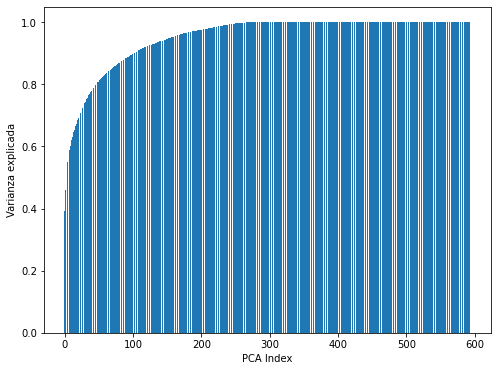

In [33]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X)
pca.explained_variance_ratio_

plt.figure(figsize=(8,6))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum())
plt.ylabel('Varianza explicada')   # puedo definir un corte en la cantidad de Z que quiero de acuerdo a la cantidad acumulada de varianza explicada.
plt.xlabel('PCA Index')  # lo ideal es quedarse con una varianza acumulada del 60% (en este caso las tres primeras barras explcian el 60% de la varianza explicada)
plt.show()
#pca.explained_variance_ratio_.cumsum()

In [34]:
info=pca.explained_variance_ratio_.cumsum()

In [35]:
n=0
for i in info:
    if i<0.8:
        n+=1
print(n)

46


In [36]:
info[:42]

array([0.39168675, 0.46010373, 0.50060149, 0.52676694, 0.55138921,
       0.56460968, 0.57711768, 0.58951004, 0.60139367, 0.61196325,
       0.62102342, 0.62963658, 0.63794138, 0.64603951, 0.6530885 ,
       0.66011923, 0.66692041, 0.67346955, 0.67964917, 0.68570349,
       0.69154718, 0.69736013, 0.70309021, 0.70859203, 0.7140399 ,
       0.71933743, 0.72461058, 0.72979844, 0.73474167, 0.73939101,
       0.7439878 , 0.74856122, 0.75282878, 0.75708134, 0.76121114,
       0.76519137, 0.7689687 , 0.77272364, 0.77620495, 0.77965439,
       0.78280544, 0.78589684])

In [37]:
pca = PCA(n_components=42)
X_train_pca = pca.fit_transform(X)

In [38]:
X_train, X_test, y_train, y_test = train_test_split( X_train_pca, y, test_size=0.3,stratify=y)

In [39]:
dfy=pd.DataFrame(y_train)

In [40]:
dfy.value_counts()

clase
0        297
1        168
2         34
dtype: int64

In [41]:
from sklearn import tree
clasificador = tree.DecisionTreeClassifier(criterion="entropy")

In [42]:
X=X_train_pca
y=df_tra["clase"]

In [43]:
y2=list()
lista_yhat=[]
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clasificador.fit(X_train, y_train)
    yhat = clasificador.predict(X_test)
    y2.extend(y_test)
    lista_yhat.extend(yhat)

In [44]:
print("Jaccard index: " , jaccard_score(y2, lista_yhat, average="macro"))
print("Exactitud: " , accuracy_score(y2, lista_yhat))
print("Precisión: ", precision_score(y2, lista_yhat, average="macro"))
print("Sensibilidad: ", recall_score(y2, lista_yhat, average="macro"))
print("F1-score: ", f1_score(y2, lista_yhat, average="macro"))

Jaccard index:  0.22814786671169648
Exactitud:  0.5399719495091164
Precisión:  0.35504770371943045
Sensibilidad:  0.34088235294117647
F1-score:  0.32777894121926215


[[339  75  11]
 [192  44   4]
 [ 41   5   2]]


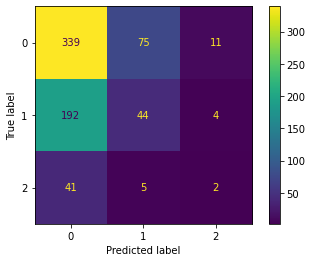

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y2, lista_yhat)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### MODELO DE CLUSTERING

C:\Users\david\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


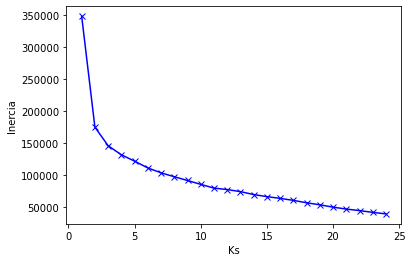

In [46]:
inercias = [] 
  
for k in range(1,25): 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)     
    inercias.append(kmeans.inertia_) 
inercias
plt.plot(range(1,25), inercias, 'bx-') 
plt.xlabel('Ks') 
plt.ylabel('Inercia') 
plt.show()

In [47]:

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

kmeans.inertia_

131394.28535046088

In [48]:
len(kmeans.labels_)

713

In [49]:
df_comparativo=pd.DataFrame()
df_comparativo["Data related"]=df1["clase"]

In [50]:
df_comparativo["Kmeans_label"]=kmeans.labels_

In [51]:
df_comparativo

,Data related,Kmeans_label
1,0.0,1
2,0.0,0
3,0.0,1
4,0.0,0
5,0.0,0
...,...,...
1235,0.0,0
1237,0.0,0
1238,0.0,0
1239,0.0,0


In [52]:
df_comparativo.groupby("Kmeans_label")["Data related"].value_counts()

Kmeans_label  Data related
0             0.000000        704
              6.877736          1
1             0.000000          2
2             0.000000          2
3             0.000000          4
Name: Data related, dtype: int64

In [53]:
df_comparativo[df_comparativo["Kmeans_label"]==2]

,Data related,Kmeans_label
368,0.0,2
382,0.0,2


In [54]:
df.iloc[381]

#                                                            381
n_perfil                                                     210
Cargo                                             Data Scientist
Empresa                                                  Quental
Fechas                                     may 2021 – actualidad
descripcion    As a data scientist I have been working, in th...
jornada                                         Jornada completa
Name: 381, dtype: object

In [55]:
df.iloc[368]

#                                                            368
n_perfil                                                     207
Cargo                                             Data Scientist
Empresa                                        Strategy Big Data
Fechas                                       may 2019 – abr 2021
descripcion    As a data scientist I have worked on the devel...
jornada                                         Jornada completa
Name: 368, dtype: object